In [8]:
import logging
import time
import io
from pathlib import Path
from typing import List, Optional

import pandas as pd
import requests
import yfinance as yf

SP500_WIKI_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
DEFAULT_USER_AGENT = (
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
    "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class DataEngine:
    def __init__(self, storage_path: str = "data/raw"):
        self.storage_path = Path(storage_path)
        self.storage_path.mkdir(parents=True, exist_ok=True)
        self.universe: List[str] = []

    def get_sp500_universe(self) -> List[str]:
        logger.info("Synchronizing S&P 500 universe from source...")
        headers = {"User-Agent": DEFAULT_USER_AGENT}
        try:
            response = requests.get(SP500_WIKI_URL, headers=headers, timeout=15)
            response.raise_for_status()
            df = pd.read_html(io.StringIO(response.text))[0]
            self.universe = [str(symbol).replace('.', '-') for symbol in df['Symbol'].unique()]
            logger.info(f"Universe synchronized: {len(self.universe)} tickers identified.")
            return self.universe
        except Exception as e:
            logger.error(f"Failed to define universe: {e}")
            return []

    def fetch_historical_data(self, tickers: List[str], start: str, end: str) -> None:
        logger.info(f"Initiating batch download for {len(tickers)} assets.")
        for ticker in tickers:
            try:
                df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
                
                if df.empty:
                    continue

                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.get_level_values(0)
                
                df.columns = [str(c).lower().strip() for c in df.columns]
                
                df = df.dropna(how='all')

                if 'ticker' in df.columns:
                    df = df.drop(columns=['ticker'])

                output_file = self.storage_path / f"{ticker}.parquet"
                df.to_parquet(output_file, engine='pyarrow', compression='snappy')
                logger.info(f"Stored: {ticker}")
                time.sleep(0.35)
            except Exception as e:
                logger.error(f"Critical failure on ticker {ticker}: {e}")

    def merge_all_data(self) -> pd.DataFrame:
        logger.info("Merging local Parquet files into master DataFrame...")
        all_dfs = []
        for file in self.storage_path.glob("*.parquet"):
            try:
                df = pd.read_parquet(file)
                df['ticker'] = file.stem
                all_dfs.append(df)
            except Exception as e:
                logger.error(f"Failed to read {file.name}: {e}")
        
        if not all_dfs:
            return pd.DataFrame()
            
        master_df = pd.concat(all_dfs)
        master_df.index.name = 'date'
        master_df = master_df.reset_index()
        
        cols_to_keep = ['date', 'ticker', 'open', 'high', 'low', 'close', 'volume']
        master_df = master_df[[c for c in cols_to_keep if c in master_df.columns]]
        
        master_df = master_df.dropna(subset=['close'])
        master_df = master_df.sort_values(['ticker', 'date']).reset_index(drop=True)
        
        logger.info(f"Master DataFrame created. Shape: {master_df.shape}")
        return master_df

if __name__ == "__main__":
    engine = DataEngine()
    assets = engine.get_sp500_universe()
    if assets:
        test_slice = assets[:5]
        engine.fetch_historical_data(test_slice, "2020-01-01", "2023-12-31")
        master_data = engine.merge_all_data()
        if not master_data.empty:
            print(master_data.head(10))
    logger.info("ETL Pipeline completed successfully.")

22:47:47 - INFO - Synchronizing S&P 500 universe from source...
22:47:49 - INFO - Universe synchronized: 503 tickers identified.
22:47:49 - INFO - Initiating batch download for 5 assets.
22:47:49 - INFO - Stored: MMM
22:47:50 - INFO - Stored: AOS
22:47:50 - INFO - Stored: ABT
22:47:51 - INFO - Stored: ABBV
22:47:51 - INFO - Stored: ACN
22:47:52 - INFO - Merging local Parquet files into master DataFrame...
22:47:52 - INFO - Master DataFrame created. Shape: (5030, 7)
22:47:52 - INFO - ETL Pipeline completed successfully.


        date ticker       open       high        low      close     volume
0 2020-01-02   ABBV  68.902617  69.281626  68.461727  69.266159  5639200.0
1 2020-01-03   ABBV  68.198731  69.142392  67.989891  68.608681  5988500.0
2 2020-01-06   ABBV  68.237411  69.320300  68.051775  69.150131  6786600.0
3 2020-01-07   ABBV  68.786617  69.258447  68.268379  68.755676  7242500.0
4 2020-01-08   ABBV  68.956770  69.660644  68.740193  69.242958  7696800.0
5 2020-01-09   ABBV  69.621976  69.792145  68.879425  69.776672  7518000.0
6 2020-01-10   ABBV  69.792143  69.838551  68.709254  68.887154  8581400.0
7 2020-01-13   ABBV  69.227468  69.227468  68.005351  68.469444  9292200.0
8 2020-01-14   ABBV  68.281319  69.331804  68.022617  69.143654  8876900.0
9 2020-01-15   ABBV  69.127974  70.460672  69.127974  69.974632  8490100.0


In [9]:
import logging
from pathlib import Path
from typing import List, Union

import numpy as np
import pandas as pd

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class FeatureEngineer:
    def __init__(self, raw_dir: str = "data/raw", processed_dir: str = "data/processed"):
        self.raw_path = Path(raw_dir)
        self.processed_path = Path(processed_dir)
        self.processed_path.mkdir(parents=True, exist_ok=True)

    def _generate_signals(self, df: pd.DataFrame) -> pd.DataFrame:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        
        df.columns = [str(c).lower().strip() for c in df.columns]

        if 'close' not in df.columns:
            raise KeyError(f"Required column 'close' not found. Available: {list(df.columns)}")

        close = df['close']
        
        df['log_return'] = np.log(close / close.shift(1))
        
        df['volatility_21d'] = df['log_return'].rolling(window=21).std() * np.sqrt(252)
        
        df['sma_50'] = close.rolling(window=50).mean()
        df['sma_200'] = close.rolling(window=200).mean()
        df['distance_sma_200'] = (close / df['sma_200']) - 1
        df['sma_ratio'] = df['sma_50'] / df['sma_200']
        
        df['target_next_return'] = df['log_return'].shift(-1)
        
        return df.dropna()

    def run_pipeline(self, tickers: Union[List[str], str] = "all"):
        if tickers == "all":
            tickers = [f.stem for f in self.raw_path.glob("*.parquet")]

        logger.info(f"Processing features for {len(tickers)} assets...")

        for ticker in tickers:
            input_file = self.raw_path / f"{ticker}.parquet"
            output_file = self.processed_path / f"{ticker}_features.parquet"

            if not input_file.exists():
                logger.warning(f"Source file not found for {ticker}. Skipping.")
                continue

            try:
                df = pd.read_parquet(input_file)
                df_features = self._generate_signals(df)
                
                df_features.to_parquet(output_file, compression='snappy')
                logger.info(f"Feature set finalized: {ticker}")
                
            except Exception as e:
                logger.error(f"Pipeline failure for {ticker}: {str(e)}")

if __name__ == "__main__":
    engineer = FeatureEngineer()
    engineer.run_pipeline()

22:51:31 - INFO - Processing features for 10 assets...
22:51:31 - INFO - Feature set finalized: A
22:51:31 - INFO - Feature set finalized: ABBV
22:51:31 - INFO - Feature set finalized: ABT
22:51:31 - INFO - Feature set finalized: ACN
22:51:31 - INFO - Feature set finalized: ADBE
22:51:31 - INFO - Feature set finalized: AES
22:51:32 - INFO - Feature set finalized: AFL
22:51:32 - INFO - Feature set finalized: AMD
22:51:32 - INFO - Feature set finalized: AOS
22:51:32 - INFO - Feature set finalized: MMM


[INFO] Initiating backtest for ABBV...



═════════════════════════════════════════════
         STRATEGY PERFORMANCE REPORT         
═════════════════════════════════════════════
CAGR                      |          11.65%
Annual Volatility         |          19.52%
Sharpe Ratio              |            0.57
Max Drawdown              |         -35.20%
Total Return              |          42.27%
═════════════════════════════════════════════



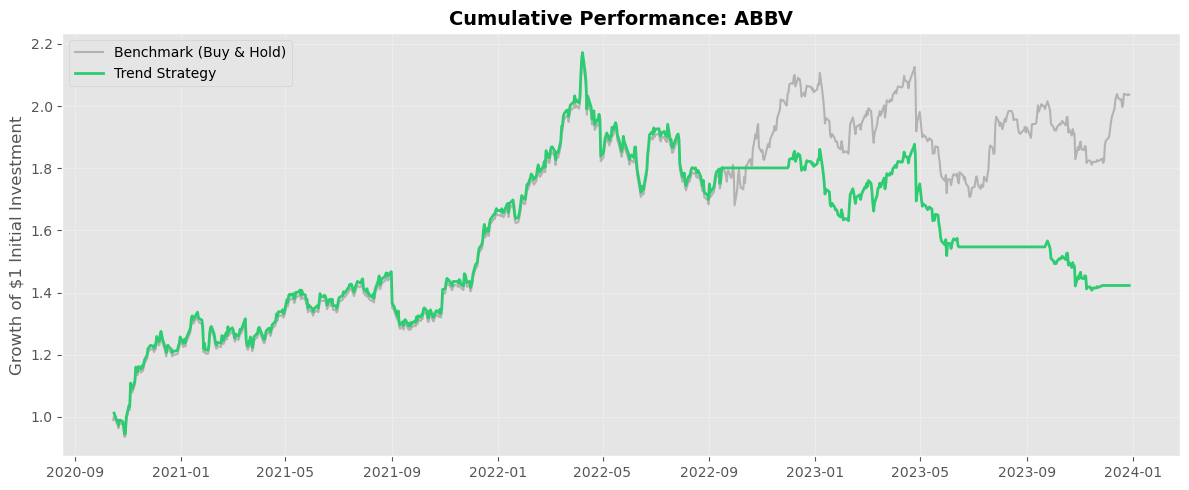

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)

class QuantitativeBacktester:
    def __init__(self, data_path: str = "data/processed/"):
        self.data_path = data_path
        self.results = None
        self.metrics = {}

    def run_strategy(self, ticker_file: str):
        full_path = os.path.join(self.data_path, ticker_file)
        
        try:
            df = pd.read_parquet(full_path)
            
            df['signal'] = np.where(df['sma_50'] > df['sma_200'], 1, 0)
            
            df['strategy_returns'] = df['signal'].shift(1) * df['log_return']
            
            df['equity_market'] = df['log_return'].cumsum().apply(np.exp)
            df['equity_strategy'] = df['strategy_returns'].cumsum().apply(np.exp)
            
            self.results = df
            return self.results
            
        except Exception as e:
            logger.error(f"Error during backtest: {e}")
            return None

    def compute_performance_analytics(self, risk_free_rate: float = 0.0):
        if self.results is None:
            return

        df = self.results
        returns = df['strategy_returns'].dropna()
        
        total_return = df['equity_strategy'].iloc[-1]
        num_years = len(df) / 252
        cagr = (total_return ** (1 / num_years)) - 1
        
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = ((returns.mean() - risk_free_rate) / returns.std()) * np.sqrt(252)
        
        peak = df['equity_strategy'].cummax()
        drawdown = (df['equity_strategy'] - peak) / peak
        max_dd = drawdown.min()

        self.metrics = {
            "CAGR": f"{cagr:.2%}",
            "Annual Volatility": f"{volatility:.2%}",
            "Sharpe Ratio": f"{sharpe_ratio:.2f}",
            "Max Drawdown": f"{max_dd:.2%}",
            "Total Return": f"{(total_return - 1):.2%}"
        }
        
        self._display_report()

    def _display_report(self):
        print("\n" + "═"*45)
        print(f"{'STRATEGY PERFORMANCE REPORT':^45}")
        print("═"*45)
        for metric, value in self.metrics.items():
            print(f"{metric:<25} | {value:>15}")
        print("═"*45 + "\n")

    def plot_equity_curve(self, ticker: str):
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(12, 5))
        
        ax.plot(self.results['equity_market'], label='Benchmark (Buy & Hold)', color='gray', alpha=0.5)
        ax.plot(self.results['equity_strategy'], label='Trend Strategy', color='#2ecc71', lw=2)
        
        ax.set_title(f"Cumulative Performance: {ticker}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Growth of $1 Initial Investment")
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    backtester = QuantitativeBacktester()
    
    if os.path.exists("data/processed/"):
        files = [f for f in os.listdir("data/processed/") if f.endswith(".parquet")]
        
        if files:
            target = files[0]
            ticker = target.split('_')[0]
            
            logger.info(f"Initiating backtest for {ticker}...")
            
            if backtester.run_strategy(target) is not None:
                backtester.compute_performance_analytics()
                backtester.plot_equity_curve(ticker)

In [2]:
import os
import pandas as pd
import numpy as np

def calculate_strategy_metrics(df, trading_days=252):
    df.columns = [str(c).lower().strip() for c in df.columns]
    
    df['position'] = np.where(df['sma_50'] > df['sma_200'], 1, 0)
    df['strategy_returns'] = df['position'].shift(1) * df['log_return']
    df['cumulative_strategy'] = df['strategy_returns'].cumsum().apply(np.exp)
    
    strategy_std = df['strategy_returns'].std()
    sharpe = (df['strategy_returns'].mean() / strategy_std) * np.sqrt(trading_days) if strategy_std != 0 else 0
    total_return = (df['cumulative_strategy'].iloc[-1] - 1) * 100
    
    return round(sharpe, 2), round(total_return, 2)

def run_backtest_suite(data_dir="data/processed/"):
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory not found: {data_dir}")

    files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
    results = []

    for file in files:
        ticker = file.split('_')[0]
        path = os.path.join(data_dir, file)
        
        try:
            df = pd.read_parquet(path)
            sharpe, ret = calculate_strategy_metrics(df)
            
            results.append({
                'Ticker': ticker,
                'Sharpe_Ratio': sharpe,
                'Total_Return_Pct': ret
            })
        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    leaderboard = pd.DataFrame(results).sort_values(by='Sharpe_Ratio', ascending=False)
    
    header = " QUANT UNIVERSE PERFORMANCE SUMMARY "
    print(f"\n{header:=^50}")
    print(leaderboard.to_string(index=False, justify='center'))
    print(f"{'':=^50}\n")
    
    return leaderboard

if __name__ == "__main__":
    performance_report = run_backtest_suite()


======= QUANT UNIVERSE PERFORMANCE SUMMARY =======
Ticker  Sharpe_Ratio  Total_Return_Pct
  AFL       1.04            96.49     
  ACN       0.90            65.44     
  AOS       0.63            61.55     
 ABBV       0.57            42.27     
  AMD       0.52            85.62     
    A       0.42            28.35     
 ADBE       0.41            37.75     
  AES       0.25            19.09     
  MMM       0.23             8.17     
  ABT      -0.25           -12.38     



In [3]:
import pandas as pd
import logging
import os

logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)

def get_active_signals(leaderboard_df, sharpe_threshold=0.4):
    signals = {}
    
    candidates = leaderboard_df[leaderboard_df['Sharpe_Ratio'] > sharpe_threshold]['Ticker'].tolist()
    
    if not candidates:
        logging.warning("No candidates met the Sharpe Ratio threshold.")
        return signals

    logging.info(f"Processing signals for {len(candidates)} candidates...")

    for ticker in candidates:
        try:
            file_path = f"data/processed/{ticker}_features.parquet"
            
            if not os.path.exists(file_path):
                logging.warning(f"Data file missing for {ticker}: {file_path}")
                continue

            df = pd.read_parquet(file_path)
            
            df.columns = [str(c).lower().strip() for c in df.columns]
            
            if df.empty or 'sma_50' not in df.columns or 'sma_200' not in df.columns:
                logging.warning(f"Incomplete data attributes for {ticker}")
                continue

            last_sma_50 = float(df['sma_50'].iloc[-1])
            last_sma_200 = float(df['sma_200'].iloc[-1])
            
            is_bullish = last_sma_50 > last_sma_200
            signals[ticker] = "BULLISH" if is_bullish else "BEARISH"
            
        except Exception as e:
            logging.error(f"Unexpected error processing {ticker}: {str(e)}")
            
    return signals

if 'performance_report' in locals():
    active_signals = get_active_signals(performance_report)
else:
    print("Error: performance_report from Cell 4 not found in memory.")
    active_signals = {}

print("\n" + "="*35)
print(f"{'STRATEGY MONITOR':^35}")
print("="*35)
print(f"{'TICKER':<15} | {'MARKET BIAS':<15}")
print("-" * 35)

if active_signals:
    for ticker, bias in active_signals.items():
        print(f"{ticker:<15} | {bias:<15}")
else:
    print("No active signals generated.")

print("="*35 + "\n")

[INFO] Processing signals for 7 candidates...



         STRATEGY MONITOR          
TICKER          | MARKET BIAS    
-----------------------------------
AFL             | BULLISH        
ACN             | BULLISH        
AOS             | BULLISH        
ABBV            | BEARISH        
AMD             | BULLISH        
A               | BEARISH        
ADBE            | BULLISH        



In [4]:
import os

current_dir = os.getcwd()
file_name = "quant_leaderboard_results.csv"
full_path = os.path.join(current_dir, file_name)

if 'performance_report' in locals():
    performance_report.to_csv(full_path, index=False)
    print(f"Success: File saved at {full_path}")
else:
    print("Error: performance_report variable not found.")

Success: File saved at c:\Users\vwarr\Desktop\Quant_Project\data\src\quant_leaderboard_results.csv
